## Notebook to test an ensemble learning model of the top 3-5 model from Algorithm_Test_3

In [ ]:
#Imports
import numpy as np
import pandas as pd
import sys, os, random
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef, \
                             balanced_accuracy_score, confusion_matrix,classification_report )
from pathlib import Path
from datetime import datetime
import json
import joblib


#Warning Supression
import warnings
warnings.filterwarnings("ignore", module="skopt") #Ignore scikit-optimize warning print lines
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning) #For QDA
warnings.filterwarnings("ignore", category=UserWarning) #For LightBoost

#Class Import
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../.."))) #Allow for imports from src
from src.models import ML_Class_2
importlib.reload(ML_Class_2) #Ensures file is uptodate!
from src.models.ML_Class_2 import Model_Tester_V2

#Utils Import
from src.models.model_artifacts import (get_artifact_dir, load_model, load_models, save_model, save_models,)
ARTIFACT_DIR = get_artifact_dir("algorithm_test_3")
from src.models import model_specs
importlib.reload(model_specs) #Ensures file is uptodate!
from src.models.model_specs import MODEL_SPECS
from src.models.perf_utils import track_performance

#Set Seed
os.environ["PYTHONHASHSEED"] = "1945"
random.seed(1945)
np.random.seed(1945)

In [2]:
# --- Data Loading and Preprocessing --- 

#Complied data of convoys
#Routes examined are HX, SC, OB, ON, ONS
df = pd.read_csv('/Users/matthewplambeck/Desktop/Convoy Predictor/data/processed/Complete_Convoy_Data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.shape #Test
#Drop unecessary/redundent features
df = df.drop(columns=['Convoy Number', 'Number of Ships Sunk', 'Depart_Date', 'Arrival/Dispersal Date', 'Number of Escorts Sunk', \
                         'Number of Stragglers Sunk', 'Total Tons of Ships Sunk', 'Escort Sink Percentage', 'Straggler Sink Percentage'])
df.reset_index(drop=True).head(3)
#Feature Names for later feature analysis:
feature_names = list(df)
feature_names[:-1] #Drop Risk (y)
#Convert Overall Sink Percentage to binary 1( High)
df['Risk'] = (df['Overall Sink Percentage'] > 0).astype(int) 
#Risk is binary based off whether a ship was sunk while in a convoy:  (0 = No Ships Sunk, 1 = At Least One Ship Sunk)
X = np.array(df.drop(columns=['Overall Sink Percentage', 'Risk'])) #Remove Overall Sink Percentage as it leaks data
y = df['Risk'].values #Prediction value

In [4]:
def prepare_tester(model_key, *, scaler=None, cv_folds=None):
    spec = MODEL_SPECS[model_key]
    tester = Model_Tester_V2(
        model=spec["estimator"],
        scaler=scaler,
        parameter_grid=spec["grid_large"],
        cv_folds=cv_folds or spec.get("cv_folds", 5),
        feature_names=feature_names,
        model_config=spec["config"],)
    tester.train_test_split(X, y, train_size=0.8, random_state=1945)
    if callable(tester.parameter_grid):
        tester.parameter_grid = tester.parameter_grid(tester.y_train)
    return tester

In [6]:
# --- Load ALL MODELS FROM Alogithm_Test_3.ipynb --- 


# --- DecisionTreeClassifier ---
dt = prepare_tester("dt")
load_model("dt", directory=ARTIFACT_DIR, assign_to=dt)
# dt_results = dt.evaluate(show_plots=False)

# --- RandomForestClassifier ---
rf = prepare_tester("rf")
load_model("rf", directory=ARTIFACT_DIR, assign_to=rf)
# fr_results = rf.evaluate(show_plots=False)

# --- ExtraTreesClassifier ---
et = prepare_tester("et")
load_model("et", directory=ARTIFACT_DIR, assign_to=et)
# et_results = et.evaluate(show_plots=False)

# --- BaggingClassifier ---
bag = prepare_tester("bag")
load_model("bag", directory=ARTIFACT_DIR, assign_to=bag)
# bag_results = bag.evaluate(show_plots=False)

# --- GradientBoostingClassifier ---
gb = prepare_tester("gb")
load_model("gb", directory=ARTIFACT_DIR, assign_to=gb)
# gb_results = gb.evaluate(show_plots=False)

# --- AdaBoostClassifier ---
ada = prepare_tester("ada")
load_model("ada", directory=ARTIFACT_DIR, assign_to=ada)
# ada_results = ada.evaluate(show_plots=False)

# --- QuadraticDiscriminantAnalysis ---
qda = prepare_tester("qda")
load_model("qda", directory=ARTIFACT_DIR, assign_to=qda)
# qda_results = qda.evaluate(show_plots=False)

# --- XGBClassifier ---
xgb = prepare_tester("xgb")
load_model("xgb", directory=ARTIFACT_DIR, assign_to=xgb)
# xgb_results = xgb.evaluate(show_plots=False)

# --- XGBRFClassifier ---
xgbrf = prepare_tester("xgbrf")
load_model("xgbrf", directory=ARTIFACT_DIR, assign_to=xgbrf)
# xgbrf_results = xgbrf.evaluate(show_plots=False)

# --- LGBMClassifier ---
lgbm = prepare_tester("lgbm")
load_model("lgbm", directory=ARTIFACT_DIR, assign_to=lgbm)
# lgbm_results = lgbm.evaluate(show_plots=False)

# --- CatBoostClassifier ---
cat = prepare_tester("cat")
load_model("cat", directory=ARTIFACT_DIR, assign_to=cat)
# cat_results = cat.evaluate(show_plots=False)



In [8]:
# --- Preliminary soft-voting ensemble using loaded models ---

def evaluate_voting_ensemble(
    estimators_dict,
    X_train, X_test, y_train, y_test,
    threshold: float = 0.5, #Hard coded in. Subsquent threshold comparison below. 
    voting: str = "soft",
    ensemble_name: str | None = None,
    pos_label: int = 1,
    verbose: bool = True,):
    """
    Build, fit and evaluate a VotingClassifier ensemble.

    Parameters
    ----------
    estimators_dict : dict
        Dict of {name: fitted_estimator} to include in the ensemble.
    X_train, X_test, y_train, y_test : array-like
        Train/test split (same as used to train base models).
    threshold : float, default=0.5
        Decision threshold applied to P(y=pos_label).
        Only used for soft voting.
    voting : {"soft", "hard"}, default="soft"
        Voting strategy for VotingClassifier.
    ensemble_name : str, optional
        Name for the ensemble in the results table. If None, uses
        "VotingEnsemble_" + "_".join(sorted(estimators_dict.keys())).
    pos_label : int, default=1
        Positive class label.
    verbose : bool, default=True
        If True, prints metrics, confusion matrix, and classification report.

    Returns
    -------
    results_df : pd.DataFrame
        One-row dataframe with metrics.
    voter : VotingClassifier
        The fitted VotingClassifier instance.
    cm_df : pd.DataFrame
        Confusion matrix as a dataframe.
    cls_report : str
        Text classification report.
    """

    #Build estimator list for VotingClassifier
    estimators_list = [(name, est) for name, est in estimators_dict.items()]

    if ensemble_name is None:
        ensemble_name = "VotingEnsemble_" + "_".join(sorted(estimators_dict.keys()))

    voter = VotingClassifier(
        estimators=estimators_list,
        voting=voting,
        n_jobs=-1,)

    #Fit Ensemble Model
    voter.fit(X_train, y_train)

    #Get scores & predictions
    if voting == "soft":
        proba_pos = voter.predict_proba(X_test)[:, 1]
        y_pred = (proba_pos >= threshold).astype(int)
    else:
        #For hard voting, no probabilities – just use predicted labels.
        y_pred = voter.predict(X_test)
        proba_pos = None  #placeholder

    #Metrics
    if proba_pos is not None:
        roc_auc = roc_auc_score(y_test, proba_pos)
    else:
        roc_auc = np.nan

    acc = np.mean(y_pred == y_test)
    recall_1 = recall_score(y_test, y_pred, pos_label=pos_label)
    precision_1 = precision_score(y_test, y_pred, pos_label=pos_label)
    f1_1 = f1_score(y_test, y_pred, pos_label=pos_label)
    mcc = matthews_corrcoef(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=['True 0', 'True 1'], columns=['Pred 0', 'Pred 1'])

    cls_report = classification_report(y_test, y_pred, digits=3)

    if verbose:
        print(f"Ensemble: {ensemble_name}")
        print(f"Voting: {voting}")
        if voting == "soft":
            print(f"Threshold: {threshold:.2f}")
        print(f"ROC AUC: {roc_auc:.3f}")
        print(f"Accuracy: {acc:.3f}")
        print(f"Recall (class {pos_label}): {recall_1:.3f}")
        print(f"Precision (class {pos_label}): {precision_1:.3f}")
        print(f"F1 (class {pos_label}): {f1_1:.3f}")
        print(f"MCC: {mcc:.3f}")
        print(f"Balanced Accuracy: {bal_acc:.3f}")

        print('\nConfusion Matrix:')
        print(cm_df)

        print('\nClassification Report (digits=3):')
        print(cls_report)

    results_df = pd.DataFrame([{
        'Model': ensemble_name,
        'Threshold': threshold if voting == "soft" else np.nan,
        'Acc': acc,
        'ROC_AUC': roc_auc,
        'MCC': mcc,
        'Bal_Acc': bal_acc,
        'Recall_1': recall_1,
        'Precision_1': precision_1,
        'F1_1': f1_1,}])

    return results_df, voter, cm_df, cls_report


In [ ]:
# Decision Threshold Comparison for the voting ensemble (simple sweep)
thresholds = np.arange(0, 1.05, 0.05).tolist()
rows = []

proba_1 = voter.predict_proba(X_test)[:, 1]
for t in thresholds:
    y_pred = (proba_1 >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    rows.append({
        "threshold": t,
        "recall": recall_score(y_test, y_pred, pos_label=1),
        "precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
        "false_negatives": fn,
        "accuracy": (tp + tn) / (tp + tn + fp + fn),
        "f1": f1_score(y_test, y_pred, average="macro"),})
threshold_results = pd.DataFrame(rows)
threshold_results


,threshold,recall,precision,false_negatives,accuracy,f1
0,0.00,1.00,0.212766,0,0.212766,0.175439
1,0.05,1.00,0.212766,0,0.212766,0.175439
2,0.10,0.98,0.219731,1,0.255319,0.235325
3,0.15,0.96,0.244898,2,0.361702,0.360301
4,0.20,0.94,0.273256,3,0.455319,0.453647
5,0.25,0.92,0.323944,4,0.574468,0.559727
6,0.30,0.88,0.376068,6,0.663830,0.633110
7,0.35,0.76,0.417582,12,0.723404,0.670719
8,0.40,0.74,0.474359,13,0.770213,0.710115
9,0.45,0.68,0.485714,16,0.778723,0.709048


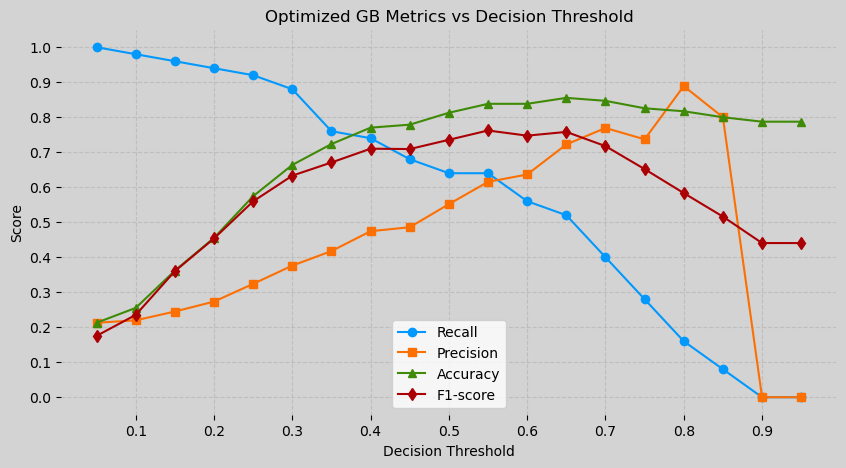

In [ ]:
#Results from above minus 0.00 and 1.00
df = threshold_results.iloc[1: -1].reset_index(drop = True)

#Plot Threshold Results:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='lightgrey')
ax.set_facecolor('lightgrey')
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.01, 0.1))
ax.plot(df["threshold"], df["recall"], label="Recall", marker='o', color='#0398fc')
ax.plot(df["threshold"], df["precision"], label="Precision", marker='s', color='#fc6f03')
ax.plot(df["threshold"], df["accuracy"], label="Accuracy", marker='^', color='#3f8a06')
ax.plot(df["threshold"], df["f1"], label="F1-score", marker='d', color='#ab0003')
plt.title("Optimized GB Metrics vs Decision Threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.grid(True, linestyle='--', alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.legend()
# plt.tight_layout()
# plt.savefig('/Users/matthewplambeck/Desktop/Convoy Predictor/Plots/Optimized_GB_Threshold_Results')
plt.show()

In [1]:
#Test
xgbrf_base

NameError: name 'xgbrf_base' is not defined